# Sidpy Complex Fitter

Here we are testing the sidpy Fitter class for SHO Fits, these are using complex data and also fancier priors.

In [ ]:
!pip install SciFiReaders pyNSID pyUSID wget sidpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pycroscopy/sidpy.git (to revision rama_dev) to /tmp/pip-req-build-r1f16rav
  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/sidpy.git /tmp/pip-req-build-r1f16rav
  Running command git checkout -b rama_dev --track origin/rama_dev
  Switched to a new branch 'rama_dev'
  Branch 'rama_dev' set up to track remote branch 'rama_dev' from 'origin'.
  Resolved https://github.com/pycroscopy/sidpy.git to commit 0da33043426bd42e0df51336aea55a37b0fb63f9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.0 MB/s eta 0:00:00
  Created wheel for sidpy: filename=sidpy-0.11.3-py2.py3-none-any.whl size=97762 sha256=f5149fbcb80137adba30ca3ba7

In [ ]:
import os
import sys

import numpy as np
import time
import h5py

import pyNSID
import matplotlib.pyplot as plt
import numba

import sidpy
#Let's open up a sample dataset and see...

import SciFiReaders as sr
from scipy.optimize import curve_fit

ModuleNotFoundError: ignored

In [ ]:
import wget
wget.download(url=r'https://www.dropbox.com/s/6jwi0bzdepjidf5/PTO_60x60_3rdarea_0003.h5?dl=1', out='beps_file.h5')

'beps_file.h5'

# Download the data

In [ ]:
beps_path = r'beps_file.h5'
reader = sr.Usid_reader(beps_path)
data_beps = reader.read() #read the data
beps_raw = data_beps[0] #take the main sidpy dataset
freq_axis = beps_raw.labels.index('Frequency (Hz)') #grab the frequency axis
freq_vec = beps_raw._axes[freq_axis].values

# Define Functions

Note that the guess function is critical here! It needs to be tuned carefully for the equation you are fitting.

In [ ]:
def SHO_fit_flattened(wvec,*p):
    Amp, w_0, Q, phi=p[0],p[1],p[2],p[3]
    func = Amp * np.exp(1.j * phi) * w_0 ** 2 / (wvec ** 2 - 1j * wvec * w_0 / Q - w_0 ** 2)
    return np.hstack([np.real(func),np.imag(func)])

def my_guess_fn(freq_vec,ydata):
    ydata = np.array(ydata)
    amp_guess = np.abs(ydata)[np.argmax(np.abs(ydata))]
    Q_guess = 50
    max_min_ratio = np.max(abs(ydata)) / np.min(abs(ydata))
    phi_guess = np.angle(ydata)[np.argmax(np.abs(ydata))]
    w_guess = freq_vec[np.argmax(np.abs(ydata))]

    #Let's just run some Q values to find the closest one
    Q_values = [5,10,20,50,100,200,500]
    err_vals = []
    for q_val in Q_values:
        p_test = [amp_guess/q_val, w_guess, q_val, phi_guess]
        func_out = SHO_fit_flattened(freq_vec,*p_test)
        complex_output = func_out[:len(func_out)//2] + 1j*func_out[(len(func_out)//2):]
        amp_output = np.abs(complex_output)
        err = np.mean((amp_output - np.abs(ydata))**2)
        err_vals.append(err)
    Q_guess = Q_values[np.argmin(err_vals)]
    p0 = [amp_guess/Q_guess, w_guess, Q_guess, phi_guess]
    return p0


## Load the data, take a small slice of it, and plot it

Here we will only consider a subset of the data. Then take a single curve fromit and then see how well our guess function performs
The guess function returns the fitting parameters that the optimization starts from, given the data.
So it is important to make sure it is somewhat close to modeling the data.


using generic parameters for dimension  3
[1.8177233869209886e-05, 376059.875, 200, -2.5212026]


Text(0.5, 1.0, 'Amplitude and Phase, with iniital guess plotted')

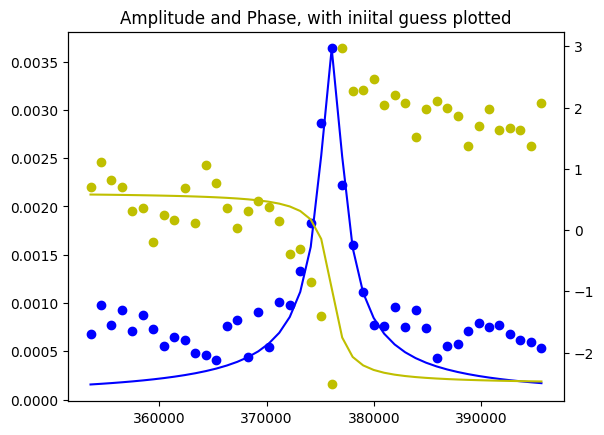

In [ ]:
beps_small = beps_raw[:5,:5,:,5:15,:]

ydata = np.array(beps_small[2,2,:,3,-1])
p0 = my_guess_fn(freq_vec, ydata)
print(p0)
ydata_guess = SHO_fit_flattened(freq_vec, *p0)
complex_output = ydata_guess[:len(ydata_guess)//2] + 1j*ydata_guess[(len(ydata_guess)//2):]
amp_output = np.abs(complex_output)
phase_output = np.angle(complex_output)

plt.figure()
plt.plot(freq_vec, np.abs(ydata), 'bo')
plt.plot(freq_vec, amp_output, 'b-')
ax2 = plt.twinx()
ax2.plot(freq_vec,np.angle(ydata), 'yo')
ax2.plot(freq_vec, phase_output, 'y-')
plt.title('Amplitude and Phase, with iniital guess plotted')


## Based on the initial guess above, perform optimization and plot

Text(0.5, 1.0, 'Amplitude and Phase, with optimized fit plotted')

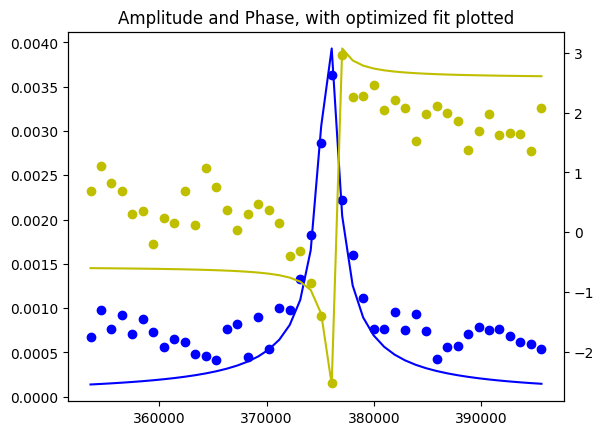

In [ ]:
ydata = np.array(ydata)
pg = my_guess_fn(freq_vec, ydata)
ydata_ri = np.hstack([np.real(ydata),np.imag(ydata)])
popt, pcov = curve_fit(SHO_fit_flattened,freq_vec, ydata_ri,p0=pg)

ydata_fit = SHO_fit_flattened(freq_vec, *popt)
complex_output = ydata_fit[:len(ydata_guess)//2] + 1j*ydata_fit[(len(ydata_guess)//2):]
amp_output = np.abs(complex_output)
phase_output = np.angle(complex_output)

plt.figure()
plt.plot(freq_vec, np.abs(ydata), 'bo')
plt.plot(freq_vec, amp_output, 'b-')
ax2 = plt.twinx()
ax2.plot(freq_vec,np.angle(ydata), 'yo')
ax2.plot(freq_vec, phase_output, 'y-')
plt.title('Amplitude and Phase, with optimized fit plotted')

# Now try the Sidpy Fitter

This can be used to fit all spectra at once. There is an option for km_guess, which determines whether the kmeans priors will be used. This means that the spectra will be clustered by KMeans into a given number of clusters, and then the guess function will be used to extract the prior for each cluster mean, and then this optimized fit will be used as priors for each cluster member.


In [ ]:
#Let's try sidpy fitter
#Instantiate the SidFitter class
fitter = sidpy.proc.fitter.SidFitter(beps_small, SHO_fit_flattened,num_workers=4,guess_fn = my_guess_fn,ind_dims=[0,1,3,4],
                           threads=1, return_cov=False, return_fit=False, return_std=False,
                           km_guess=True,num_fit_parms = 4, n_clus = 5)

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:38133
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:8787
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45173'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44227'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37661'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35209'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:44419', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:44419
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:33098
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:36079', name: 2, status: 

In [ ]:
#Note that without bounds, the fitting is not very good

lb = [0, 0, 0, -2*np.pi]
ub = [1000, np.inf, 10000, 2*np.pi]

fit_parameters = fitter.do_fit(bounds = (lb,ub))

sidpy.Dataset of type UNKNOWN with:
 dask.array<transpose, shape=(750, 44), dtype=complex64, chunksize=(750, 44), chunktype=numpy.ndarray>
 data contains: quantity (a.u.)
 and Dimensions: 
a:  generic (generic) of size (750,)
b:  generic (generic) of size (44,)
 with metadata: ['fold_attr'] complex64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:45173'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:44227'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:37661'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:35209'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:33104; closing.
INFO:distributed.core:Received 'close-stream' from t

In [ ]:
fit_parameters_mat = np.array(fit_parameters[0])

# Plot the results of 25 random spectra

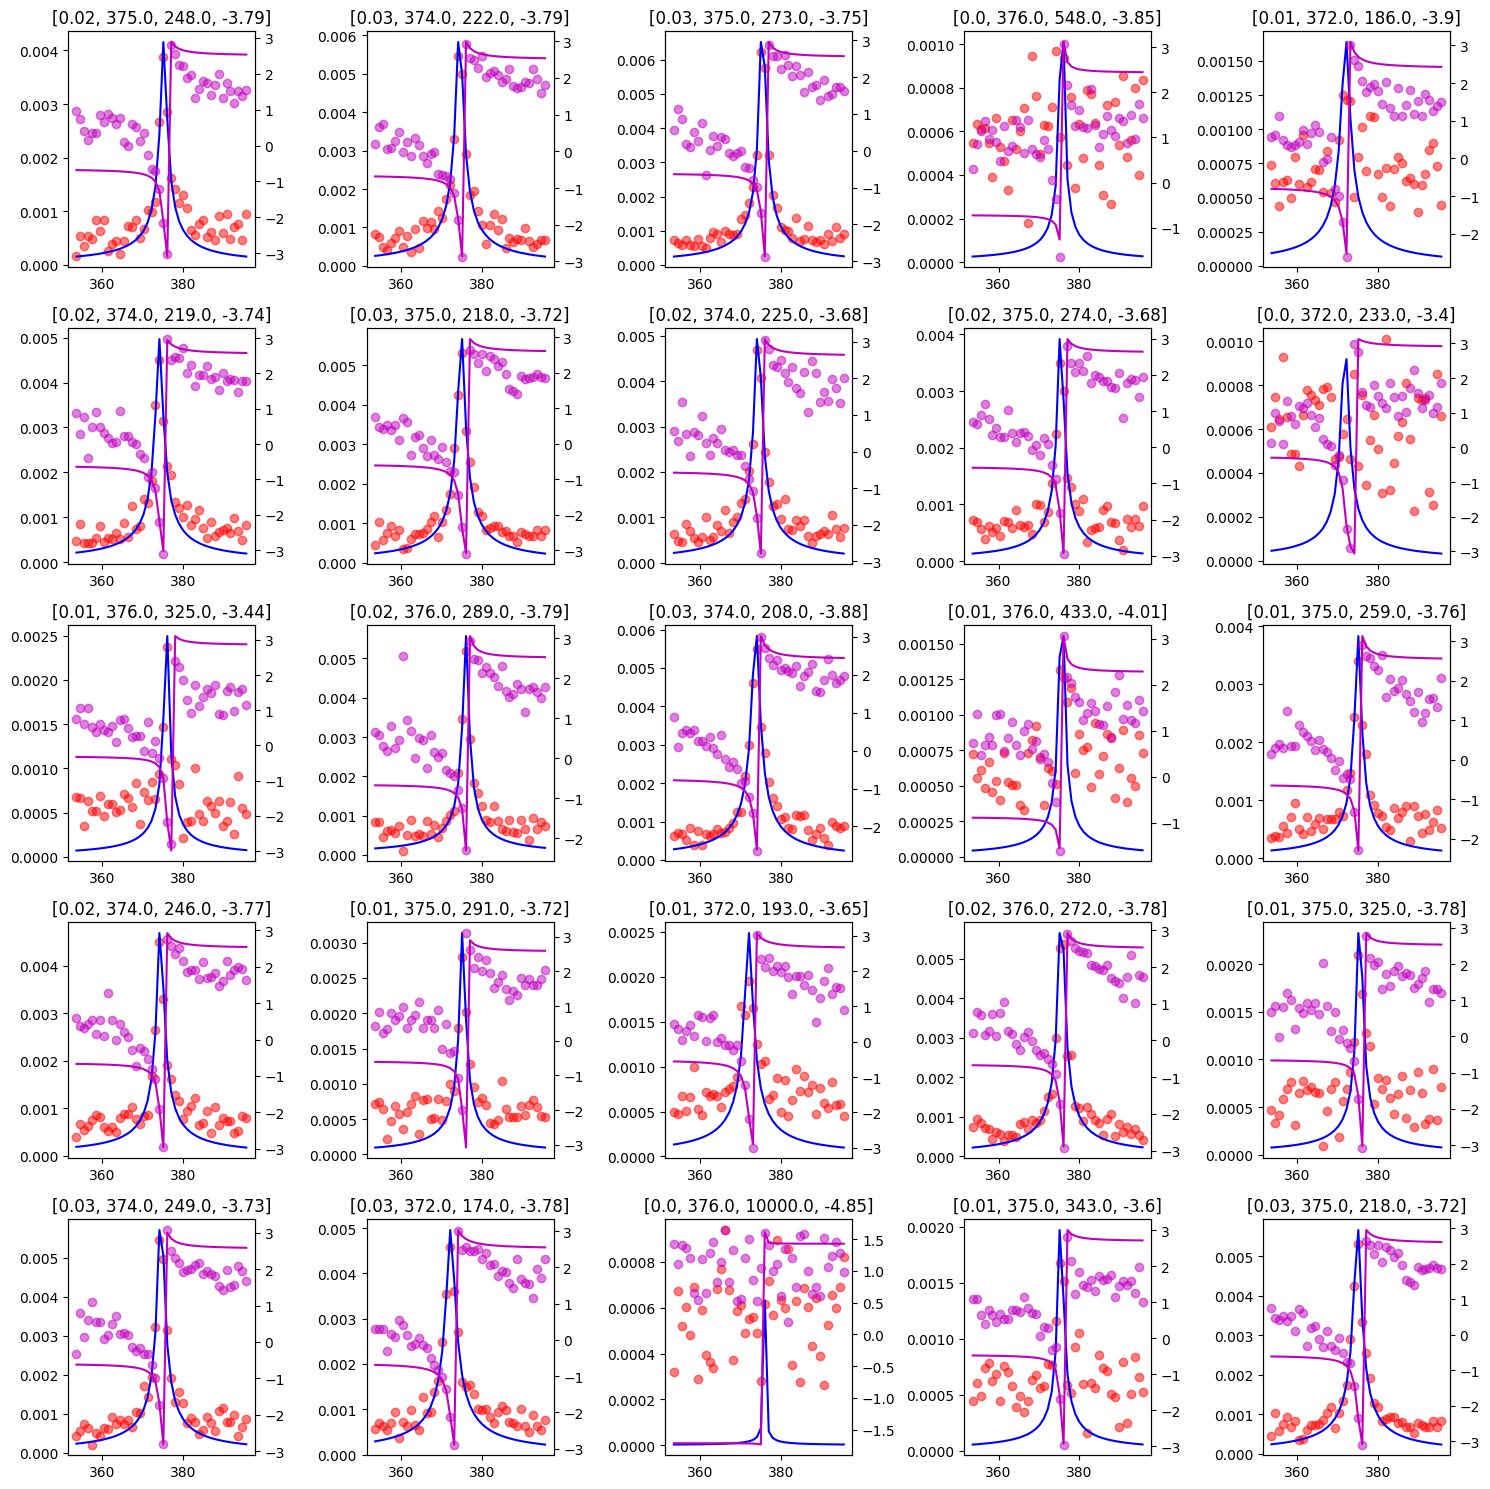

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize = (15,15))
for ind, ax in enumerate(axes.flat):
    ind_plot = [np.random.randint(low=0, high = beps_small.shape[0]),np.random.randint(low=0, high = beps_small.shape[1]),
                np.random.randint(low=0, high = beps_small.shape[3]),np.random.randint(low=0, high = beps_small.shape[4])]

    ydata = np.array(beps_small[ind_plot[0], ind_plot[1], :, ind_plot[2], ind_plot[3]])
    fit_parms = fit_parameters_mat[ind_plot[0], ind_plot[1], ind_plot[2], ind_plot[3], :]

    ydata_fit = SHO_fit_flattened(freq_vec, *fit_parms)
    complex_output = ydata_fit[:len(ydata_fit)//2] + 1j*ydata_fit[(len(ydata_fit)//2):]
    amp_fit = np.abs(complex_output)
    phase_fit = np.angle(complex_output)

    ax.plot(freq_vec/1E3, np.abs(ydata), 'ro', alpha = 0.5)
    ax.plot(freq_vec/1E3, amp_fit, 'b-')
    fit_parms_labels = [np.round(fit_parms[0]*1E3,2), np.round(fit_parms[1]/1E3 , 0), np.round(fit_parms[2],0), np.round(fit_parms[3],2)]
    ax.set_title(str(fit_parms_labels))
    ax2 = plt.twinx(ax=ax)
    ax2.plot(freq_vec/1E3, np.angle(ydata), 'mo', alpha = 0.5)
    ax2.plot(freq_vec/1E3, phase_fit, 'm-')

fig.tight_layout()